In [ ]:
!pip install gym
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/blackjack.py
!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/plotting.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-05-10 08:19:32--  https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/blackjack.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4251 (4.2K) [text/plain]
Saving to: ‘blackjack.py’

blackjack.py        100%[===================>]   4.15K  --.-KB/s    in 0s      

2023-05-10 08:19:32 (42.5 MB/s) - ‘blackjack.py’ saved [4251/4251]

--2023-05-10 08:19:32--  https://raw.githubusercontent.com/lcharlin/80-629/master/week13-RL/plotting.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443.

In [ ]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict


from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [ ]:
env = BlackjackEnv()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0, plot_every=False):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurence of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]
            
        if plot_every and i_episode % plot_every ==0:
            plotting.plot_value_function(V, title=f"{i_episode} Steps")

    return V

In [ ]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is >= 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

Episode 20000/20000.

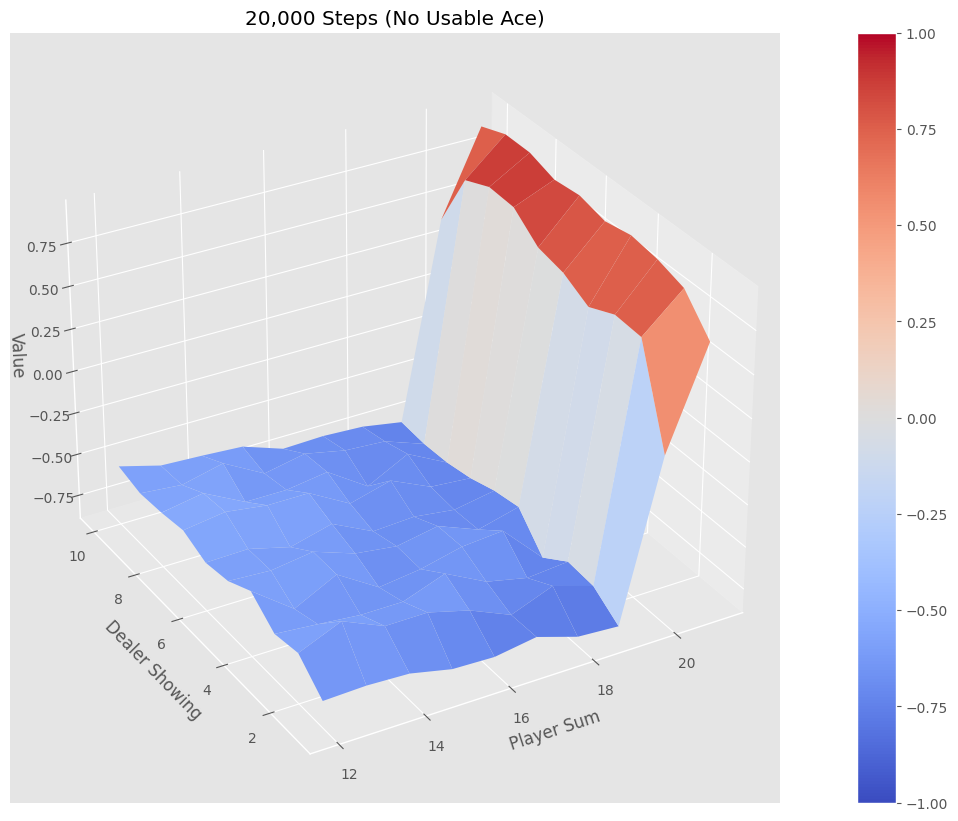

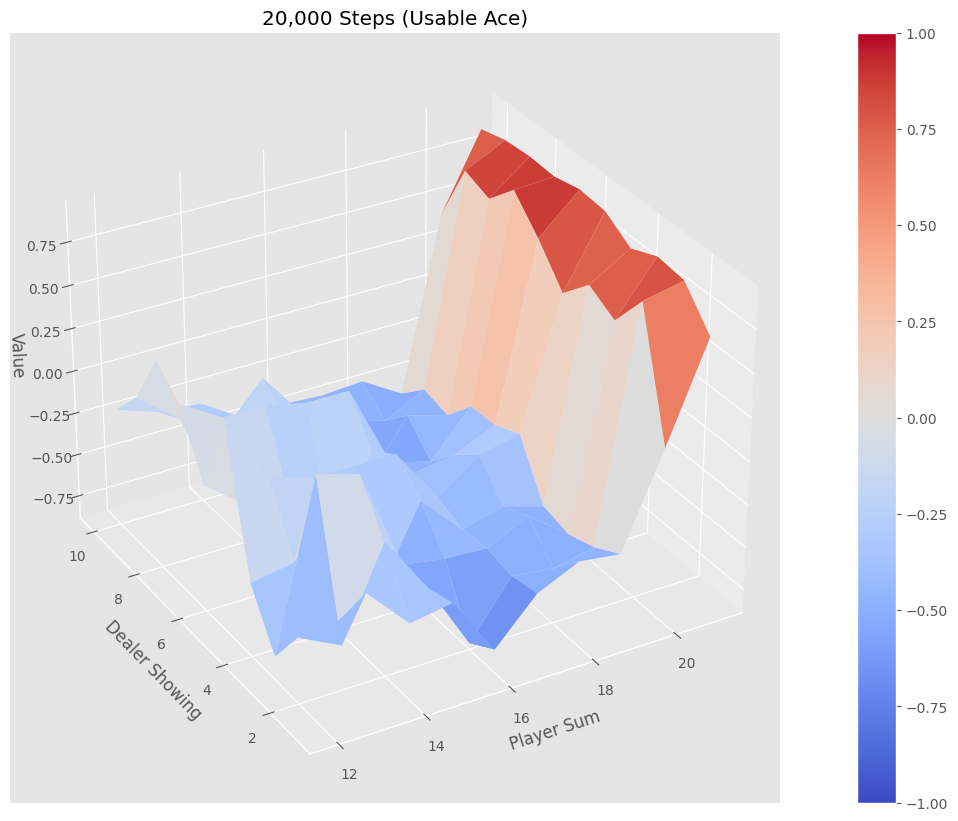

In [ ]:
V_20k = mc_prediction(sample_policy, env, num_episodes=20000)
plotting.plot_value_function(V_20k, title="20,000 Steps")

In [ ]:
V_20k = mc_prediction(sample_policy, env, num_episodes=200000, plot_every=10000)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    assert epsilon >0 and epsilon <1
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [ ]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1, plot_every=False):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all (state, action) pairs we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurance of the (state, action) pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode)
                                       if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # The policy is improved implicitly by changing the Q dictionary
    
        # plotting the value function
        if plot_every and i_episode % plot_every==0:
            V = defaultdict(float)
            for state, actions in Q.items():
                action_value = np.max(actions)
                V[state] = action_value
            plotting.plot_value_function(V, title=f"Optimal Value Function at iteration {i_episode}")

    
    return Q, policy

In [ ]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=100000, epsilon=0.1)

Episode 100000/100000.

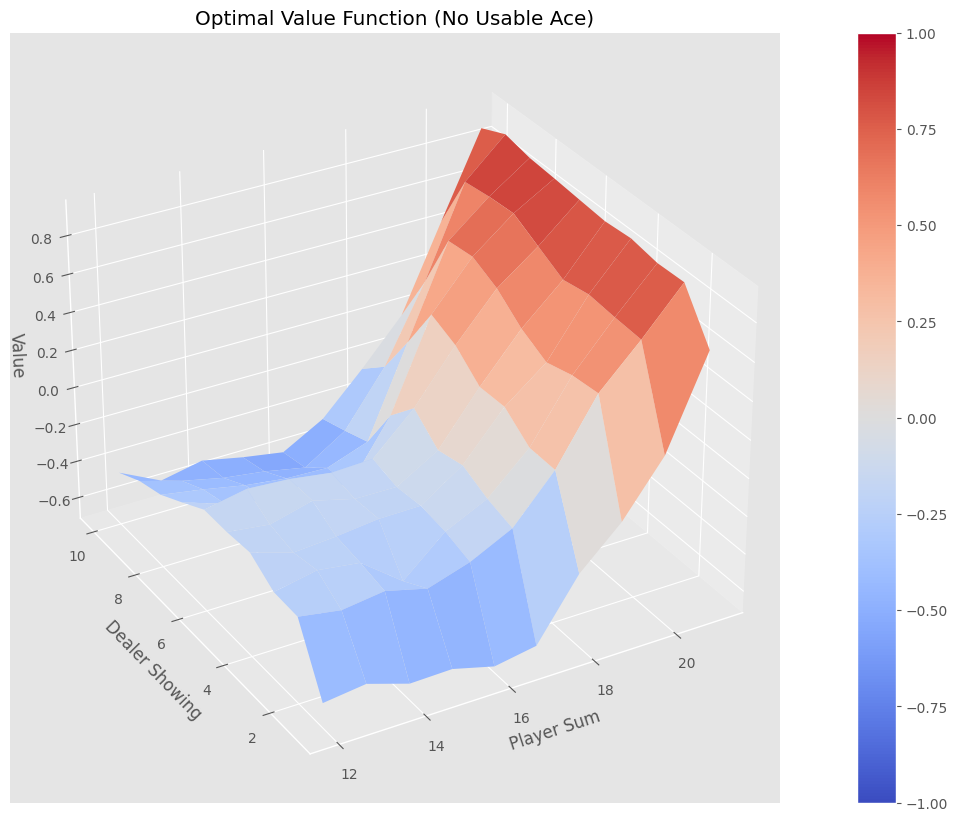

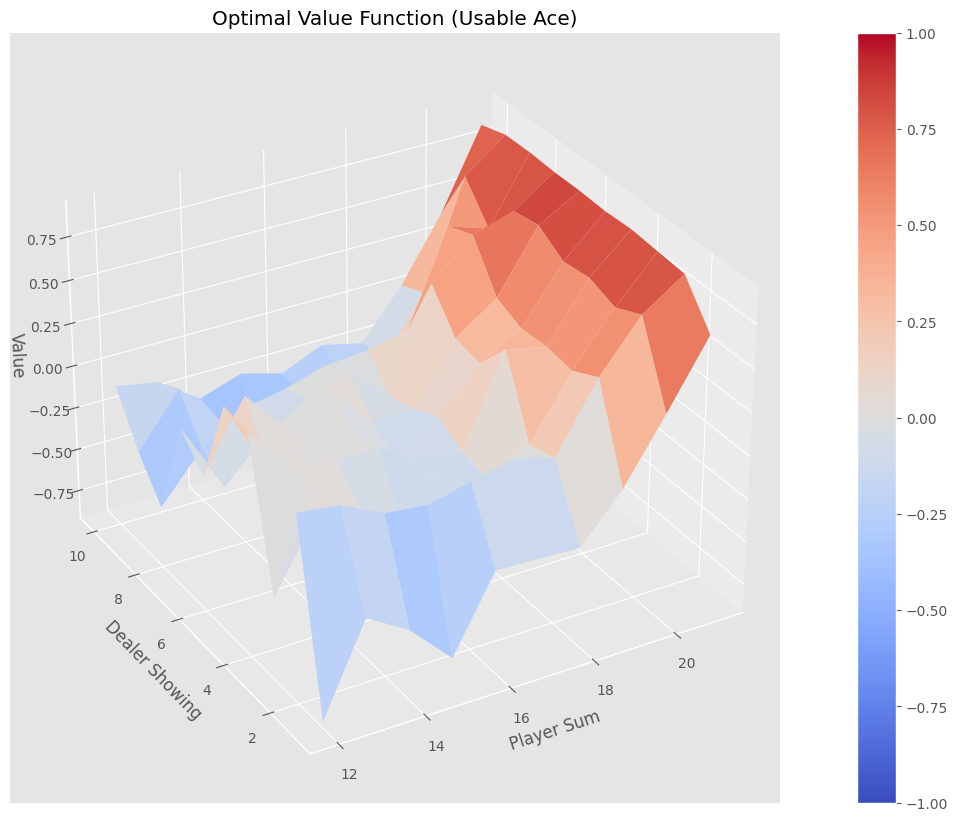

In [ ]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [ ]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1, plot_every=20000)

Output hidden; open in https://colab.research.google.com to view.